In [8]:
import pandas as pd

# Data Loading

In [9]:
from api.NN_api import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())


     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2 

# Data Split

In [10]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    x, y = data_handler.split_data(data=df_train[i], target_col='target', drop_cols=['target', 'id'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    x, y = data_handler.split_data(df_test[i], target_col='target', drop_cols=['target', 'id'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [11]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(x_train[i].head())
    print(x_test[i].head())

     col1_1  col1_2  col1_3  col2_1  col2_2  col2_3  col3_1  col3_2  col4_1  \
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     1.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     1.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     0.0     1.0     1.0   

     col4_2  col4_3  col5_1  col5_2  col5_3  col5_4  col6_1  col6_2  
NaN     0.0     0.0     0.0     0.0     1.0     0.0     1.0     0.0  
NaN     0.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0  
NaN     0.0     1.0     0.0     1.0     0.0     0.0     1.0     0.0  
NaN     0.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0  
NaN     0.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0  
     col1_1  col1_2  col1_3  col2_1  col2_2  col2_3  col3_1  col3_2  col4_1  \
NaN     1.0     0.0     0.

     col1_1  col1_2  col1_3  col2_1  col2_2  col2_3  col3_1  col3_2  col4_1  \
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     1.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     1.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   

     col4_2  col4_3  col5_1  col5_2  col5_3  col5_4  col6_1  col6_2  
NaN     0.0     0.0     0.0     1.0     0.0     0.0     0.0     1.0  
NaN     0.0     0.0     0.0     0.0     0.0     1.0     1.0     0.0  
NaN     1.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0  
NaN     1.0     0.0     1.0     0.0     0.0     0.0     0.0     1.0  
NaN     1.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0  
     col1_1  col1_2  col1_3  col2_1  col2_2  col2_3  col3_1  col3_2  col4_1  \
NaN     1.0     0.0     0.

# Grid Search parameters

In [12]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
    0: {
        'input_units': [17],
        'hidden_units': [3, 4],
        'learning_rate': [float(i/10) for i in range(1,10)], #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999],
        'batch_size': [10, 15, 30, 60],
        'epochs': [int(250+epochs) for epochs in range(0,200,20)],
        'weight_decay': [float(i/100) for i in range(1,10)] + [0.001, 0.0001], #[0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'momentum': [float(i/10) for i in range(4,9)], #[0.5, 0.6, 0.7, 0.8],
        'activation': ['tanh', 'relu'],
        'output_activation': ['sigmoid'],
        'metrics': ['accuracy']
        #'metrics_for_regularization': [] # IGNORED
    },
    1: {
        'input_units': [17],
        'hidden_units': [3, 4],
        'learning_rate': [float(i/100) for i in range(1,101,5)] + [0.999, 0.9999], #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999],
        'batch_size': [10, 15, 30, 60],
        'epochs': [int(250+epochs) for epochs in range(0,200,20)],
        'weight_decay': [float(i/1000) for i in range(1,101,5)] + [0.001, 0.0001], #[0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'momentum': [float(i/100) for i in range(50,90,5)], #[0.5, 0.6, 0.7, 0.8],
        'activation': ['tanh', 'relu'],
        'output_activation': ['sigmoid'],
        'metrics': ['accuracy']
        #'metrics_for_regularization': [] # IGNORED
    },
    2: {
        'input_units': [17],
        'hidden_units': [3, 4],
        'learning_rate': [float(i/100) for i in range(1,101,5)] + [0.999, 0.9999], #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999],
        'batch_size': [10, 15, 30, 60],
        'epochs': [int(250+epochs) for epochs in range(0,200,20)],
        'weight_decay': [float(i/1000) for i in range(1,101,5)] + [0.001, 0.0001], #[0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'momentum': [float(i/100) for i in range(50,90,5)], #[0.5, 0.6, 0.7, 0.8],
        'activation': ['tanh', 'relu'],
        'output_activation': ['sigmoid'],
        'metrics': ['accuracy']
        #'metrics_for_regularization': [] # NOT IGNORED
    },
}

# MONK 3:
# TS acc = 0.967 {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.4, 'batch_size': 30, 'epochs': 390, 'weight_decay': 0.001, 'momentum': 0.6, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
# TS acc = 0.946 {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 15, 'epochs': 390, 'weight_decay': 0.01, 'momentum': 0.8, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
# TS acc = 0.949 {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 15, 'epochs': 390, 'weight_decay': 0.005, 'momentum': 0.8, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

# MONK 2:
# TS acc = 1.000 {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.5, 'batch_size': 30, 'epochs': 390, 'weight_decay': 0.02, 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
# TS acc = 1.000 {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.5, 'batch_size': 30, 'epochs': 390, 'weight_decay': 0.03, 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

# MONK 1:
# TS acc = 1.000 {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 15, 'epochs': 390, 'weight_decay': 0.02, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
# TS acc = 0.991 {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.4, 'batch_size': 15, 'epochs': 390, 'weight_decay': 0.05, 'momentum': 0.5, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}


# Model Selection

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from api.NN_api import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: list[BinaryNN] = []

# Different values per dataset
trials_list = [30, 30, 50]
k_values = [5, 5, 5]

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values
    y = y_train[dataset_i].values
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
    for i in range(trials_list[dataset_i]):
        
        # Random parameters
        params = data_handler.random_dictionary(param_space[dataset_i])

        # Creation of the Neural Network object
        nn_i = BinaryNN(params=params, monk_i=dataset_i+1, trial=i+1)

        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            # Building the model
            nn_i.create_model(n_hidden_layers=1)

            # Training the model
            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

            # Evaluating the model
            nn_i.evaluate(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)
        
        # Print the results of this trial
        print("------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("--------------- Currently best Hyperparameters --------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Update best hyperparameters if: no high overfitting AND (higher mean VL accuracy OR (equal mean AND
        if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
            and (
                    nn[dataset_i].mean_vl_accuracy < nn_i.mean_vl_accuracy \
                or (
                    nn[dataset_i].mean_vl_accuracy == nn_i.mean_vl_accuracy and nn[dataset_i].mean_tr_accuracy < nn_i.mean_tr_accuracy
                    )
            ):
            # debug
            #print(f"--- BETTER NN PARAMETERS FOUND [{nn[dataset_i].mean_vl_accuracy} < {nn_i.mean_vl_accuracy} OR (equals AND {nn[dataset_i].mean_tr_accuracy} < {nn_i.mean_tr_accuracy})] ---")
            nn[dataset_i] = nn_i
        
        # Case of best Hyperparameters already found
        if nn[dataset_i].mean_tr_accuracy == float(1) and nn[dataset_i].mean_vl_accuracy == float(1):
            # debug
            #print(f"--- TR={nn[dataset_i].mean_tr_accuracy} VL={nn[dataset_i].mean_vl_accuracy} FOUND ---")
            break
    
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()





------------------ Current Hyperparameters ------------------
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'learning_rate': 0.5, 'batch_size': 60, 'epochs': 350, 'weight_decay': 0.02, 'momentum': 0.7, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.1256561042740941
 Mean Validation Loss:     0.12241599746048451
 Mean Training Accuracy:   0.94747474193573
 Mean Validation Accuracy: 0.9436666607856751
--------------- Currently best Hyperparameters --------------
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'learning_rate': 0.5, 'batch_size': 60, 'epochs': 350, 'weight_decay': 0.02, 'momentum': 0.7, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.1256561042740941
 Mean Validation Loss:     0.12241599746048451
 Mean T

# Print of best Hyperparameters and Plots


### Best Hyperparameters for Monk 1
 Monk:                     1
 Trial:                    8
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'learning_rate': 0.9, 'batch_size': 30, 'epochs': 270, 'weight_decay': 0.01, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.027400572039186954
 Mean Validation Loss:     0.046176479384303096
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 2
 Monk:                     2
 Trial:                    7
 Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'learning_rate': 0.56, 'batch_size': 15, 'epochs': 350, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.0029765619430691
 Mean Validation Loss:     0.0031683812849223614
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperpara

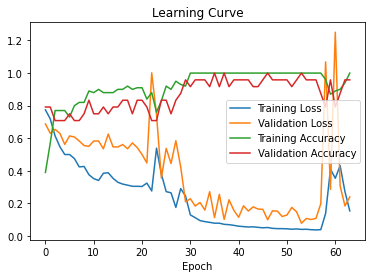

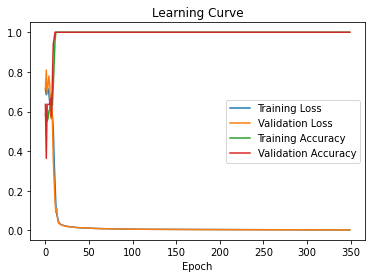

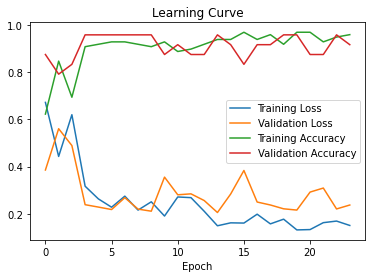

In [14]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1}")
    nn[dataset_i].print_training_info()

    # Plot the learning curve
    nn[dataset_i].print_plot()

# Retraining Phase

In [15]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Reset of the model with same Hyperparameters
    nn[dataset_i] = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, trial=1)
    
    # Building the model
    nn[dataset_i].create_model(n_hidden_layers=1)

    # Number of iteration of Retraining
    for _ in range(30):

        # Training the model
        nn[dataset_i].fit(
            x_train=x_train[dataset_i].values,
            y_train=y_train[dataset_i].values
        )

        # Evaluating the model
        nn[dataset_i].evaluate(
            x_train=x_train[dataset_i].values,
            y_train=y_train[dataset_i].values
        )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()



### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'learning_rate': 0.9, 'batch_size': 30, 'epochs': 270, 'weight_decay': 0.01, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.7270009775956472
 Mean Validation Loss:     0
 Mean Training Accuracy:   0.8583333174387614
 Mean Validation Accuracy: 0

### Retraining of Monk 2 ###
 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'learning_rate': 0.56, 'batch_size': 15, 'epochs': 350, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.0018954808319297928
 Mean Validation Loss:     0
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 0

### Retraining of Monk 3 ###
 Monk:                     3
 

# Testing Phase

 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'learning_rate': 0.9, 'batch_size': 30, 'epochs': 270, 'weight_decay': 0.01, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.7270009775956472
 Mean Validation Loss:     0
 Test Loss:                0.6793707609176636
 Mean Training Accuracy:   0.8583333174387614
 Mean Validation Accuracy: 0
 Test Accuracy:            0.9166666865348816
 f1 score:                 0.9090909090909091
 f2 score:                 0.8620689655172415
 Prediction score:         1.0
 Recall score:             0.8333333333333334

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                 36                180


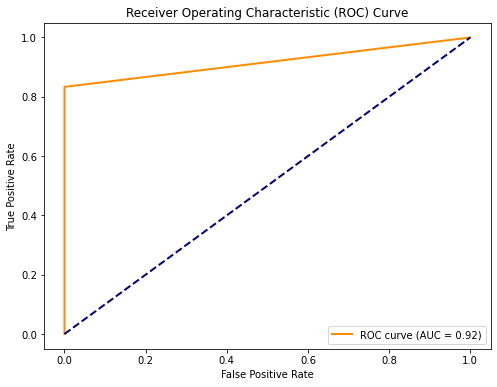

 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'learning_rate': 0.56, 'batch_size': 15, 'epochs': 350, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.0018954808319297928
 Mean Validation Loss:     0
 Test Loss:                0.0017009861767292023
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 0
 Test Accuracy:            1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Prediction score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                290                  0
Real_Class_1                  0                142


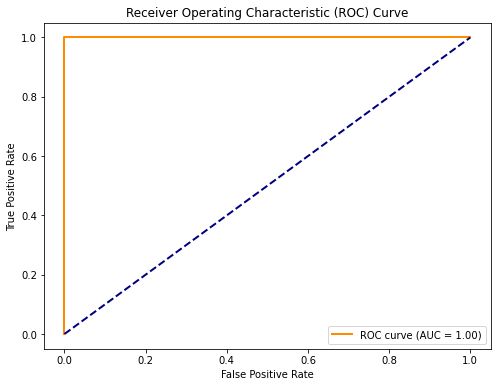

 Monk:                     3
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'learning_rate': 0.9999, 'batch_size': 10, 'epochs': 370, 'weight_decay': 0.001, 'momentum': 0.65, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.15488830308119453
 Mean Validation Loss:     0
 Test Loss:                0.21241790056228638
 Mean Training Accuracy:   0.9609289745489756
 Mean Validation Accuracy: 0
 Test Accuracy:            0.9537037014961243
 f1 score:                 0.9545454545454546
 f2 score:                 0.9341637010676157
 Prediction score:         0.9905660377358491
 Recall score:             0.9210526315789473

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                202                  2
Real_Class_1                 18                210


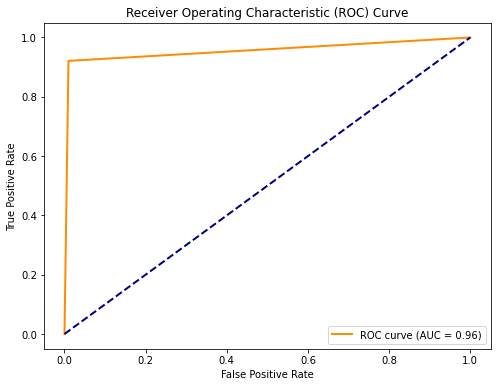

In [17]:

# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Evaluate the Model on TS set
    nn[dataset_i].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
    nn[dataset_i].score(x_test=X, y_test=y)

    # Prints the results obtained
    print(nn[dataset_i])
    nn[dataset_i].print_confusion_matrix(y_test=y)
    nn[dataset_i].print_roc_curve(y_test=y)


